### This notebook provides some examples of use of topological distillation methods.

In [1]:
from model import Base_model, FTD, HTD

from utils import train_dataset, test_dataset, evaluate, print_result, read_settings
from run import run_base, run_FTD, run_HTD
from copy import deepcopy
import time

import torch
import torch.utils.data as data
import torch.optim as optim

import random
import numpy as np

import matplotlib.pyplot as plt

## 0. Loading Dataset & Setting hyperparameters

The hyperparameters need to be determined considering dataset, base model, capacity gap, and a selected layer for distillation.
We use BPR as the base model and CiteULike for the dataset.

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# Setup
## gpu setting
gpu = torch.device('cuda:0')

## Hyperparameters for Training
lr, batch_size = 0.001, 1024
reg = 0.001

## Load dataset
user_num, item_num = 5220, 25182

train_R, train_interactions, valid_R, test_R = read_settings()
train_dataset = train_dataset(user_num, item_num, train_R, train_interactions)
test_dataset = test_dataset(user_num, item_num, valid_R, test_R)
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

run_dict = {'train_loader':train_loader, 'test_dataset':test_dataset, 'lr':lr, 'reg':reg, 'gpu':gpu, \
            'max_epoch': 100, 'eval_period':10, 'lmbda_TD': 0.001, 'alpha':0.5}

## 1. Generating Teacher Model

In [3]:
Teacher = Base_model(user_num, item_num, dim=200, gpu=gpu).to(gpu)
Teacher_history = run_base(run_dict, Teacher)

Train Done!, Recall@50: 0.3123


## 2. Guiding Student Model via Topology Distillation

In [5]:
history_dict = {}
Teacher_user_emb, Teacher_item_emb = Teacher.get_embedding()

for student_dim in [10, 20, 100, 200]:
    
    history_dict[student_dim] = []
    
    # Student
    model = Base_model(user_num, item_num, dim=student_dim, gpu=gpu).to(gpu)
    Student_history = run_base(run_dict, model)
    history_dict[student_dim].append(Student_history[:])
    
    # FTD
    model = FTD(user_num, item_num, Teacher_user_emb, Teacher_item_emb, gpu=gpu, student_dim=student_dim).to(gpu)
    FTD_history = run_FTD(run_dict, model)
    history_dict[student_dim].append(FTD_history[:])
    
    # HTD
    model = HTD(user_num, item_num, Teacher_user_emb, Teacher_item_emb, gpu=gpu, student_dim=student_dim, K=30, choice='second').to(gpu)
    HTD_history = run_HTD(run_dict, model)
    history_dict[student_dim].append(HTD_history[:])

Train Done!, Recall@50: 0.3200


## Results

### A. Model size = 0.05, 0.1

When the capacity of the student model is highly limited, the student model learns best with HTD.

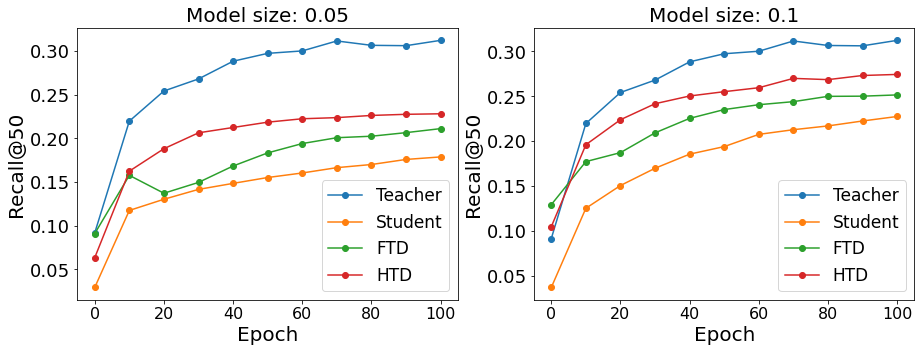

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for idx, student_dim in enumerate([10, 20]):
    
    axes[idx].plot([i for i in range(0, 101, 10)], Teacher_history, label='Teacher',  marker='o')
    axes[idx].plot([i for i in range(0, 101, 10)], history_dict[student_dim][0], label='Student', marker='o')
    axes[idx].plot([i for i in range(0, 101, 10)], history_dict[student_dim][1], label='FTD', marker='o')
    axes[idx].plot([i for i in range(0, 101, 10)], history_dict[student_dim][2], label='HTD', marker='o')

    axes[idx].legend(loc=4, fontsize=17)
    axes[idx].tick_params(axis="x", labelsize=15.9)
    axes[idx].tick_params(axis="y", labelsize=18)
    axes[idx].set_title('Model size: ' + str(student_dim / 200), fontsize=20)
    axes[idx].set_xlabel('Epoch', fontsize=20)
    axes[idx].set_ylabel('Recall@50', fontsize=20)

### B. Model size = 0.5, 1.0

As the capacity gap between the teacher model and student model decreases, the student model takes more benefits from FTD.

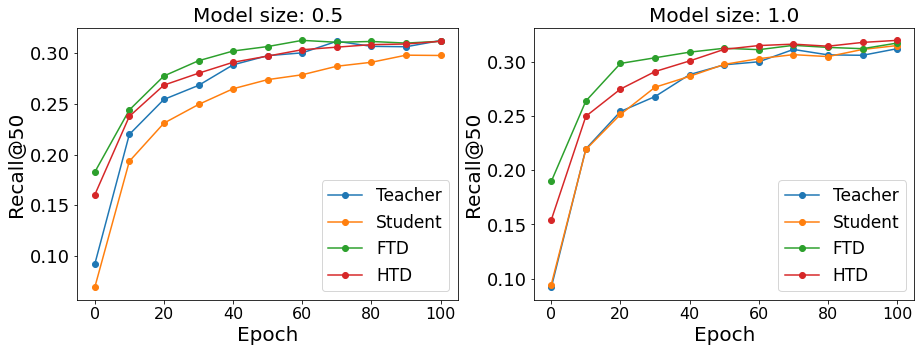

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for idx, student_dim in enumerate([100, 200]):
    
    axes[idx].plot([i for i in range(0, 101, 10)], Teacher_history, label='Teacher',  marker='o')
    axes[idx].plot([i for i in range(0, 101, 10)], history_dict[student_dim][0], label='Student', marker='o')
    axes[idx].plot([i for i in range(0, 101, 10)], history_dict[student_dim][1], label='FTD', marker='o')
    axes[idx].plot([i for i in range(0, 101, 10)], history_dict[student_dim][2], label='HTD', marker='o')

    axes[idx].legend(loc=4, fontsize=17)
    axes[idx].tick_params(axis="x", labelsize=15.9)
    axes[idx].tick_params(axis="y", labelsize=18)
    axes[idx].set_title('Model size: ' + str(student_dim / 200), fontsize=20)
    axes[idx].set_xlabel('Epoch', fontsize=20)
    axes[idx].set_ylabel('Recall@50', fontsize=20)